In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import pandas as pd
from pathlib import Path

## Load and Clean

In [3]:
data_path = Path('.') / 'data' / 'raw' / 'sent'
data_path.exists()

True

In [4]:
driver_files = list(data_path.glob('driver*.csv'))
team_files = list(data_path.glob('team*.csv'))

In [5]:
def load_from_files(files):
    df = pd.concat([pd.read_csv(f, sep='|') for f in files])
    df.drop('Unnamed: 0', axis='columns', inplace=True)
    entity_col = df.columns[0]
    
    # Clean fields that should be numeric
    df = str_to_numeric(df, cols=['Sentiment', 'Current Price', 'Season Start PriceSeason Price'])
    df['ts'] = pd.to_datetime(df['ts'])
    return df[[entity_col, 'ts'] + list(df.columns[1:-1])].sort_values(by=[entity_col, 'ts']).reset_index(drop=True)

In [6]:
def str_to_numeric(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('[\%\$m]', '', regex=True).astype(float)
    return df

In [7]:
drivers = load_from_files(driver_files)
teams = load_from_files(team_files)

In [8]:
drivers

,Driver,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million
0,Alex Albon ALB Williams,2022-06-12 15:42:57,0,0,0,-97.0,7.8,7.5,1.23
1,Alex Albon ALB Williams,2022-06-12 15:52:24,0,0,0,-97.0,7.8,7.5,1.23
2,Alex Albon ALB Williams,2022-06-12 17:10:49,2,1,0,-96.0,7.8,7.5,1.23
3,Alex Albon ALB Williams,2022-06-12 23:24:40,1,0,0,-96.0,7.8,7.5,1.23
4,Alex Albon ALB Williams,2022-06-13 09:07:54,1,0,0,-95.0,7.8,7.5,1.23
...,...,...,...,...,...,...,...,...,...
215,Yuki Tsunoda TSU AlphaTauri,2022-06-13 12:20:15,3,1,1,4.0,8.3,8.5,0.74
216,Yuki Tsunoda TSU AlphaTauri,2022-06-13 16:20:06,2,0,0,4.0,8.3,8.5,0.74
217,Yuki Tsunoda TSU AlphaTauri,2022-06-13 19:40:38,3,2,0,6.0,8.3,8.5,0.74
218,Yuki Tsunoda TSU AlphaTauri,2022-06-13 22:42:39,3,0,0,6.0,8.3,8.5,0.74


## Compare

In [9]:
diff_cols = ['ts', '12 Hour', '3 Hour', 'Latest', 'Sentiment', 'Current Price']

In [10]:
drivers_a = drivers.join(drivers.groupby(['Driver'], as_index=False)[diff_cols].diff(), rsuffix=' diff')

In [11]:
teams_a = teams.join(teams.groupby(['Team'], as_index=False)[diff_cols].diff(), rsuffix=' diff')

## Changes

In [12]:
cond_driver_price_change = (drivers_a['Current Price diff'].notna()) & (drivers_a['Current Price diff'] != 0)
drivers_a[cond_driver_price_change].dropna()

,Driver,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million,ts diff,12 Hour diff,3 Hour diff,Latest diff,Sentiment diff,Current Price diff
194,Sergio Perez PER Red Bull,2022-06-13 16:20:06,1,1,1,1.0,18.3,17.5,1.82,0 days 03:59:51,-9.0,-2.0,1.0,-97.0,0.1


In [13]:
cond_team_price_change = (teams_a['Current Price diff'].notna()) & (teams_a['Current Price diff'] != 0)
teams_a[cond_team_price_change].dropna()

,Team,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million,ts diff,12 Hour diff,3 Hour diff,Latest diff,Sentiment diff,Current Price diff
90,Red Bull,2022-06-12 17:10:49,-8,-8,89,-8.0,32.3,32.5,1.99,0 days 01:18:25,76.0,75.0,110.0,76.0,-0.1


## Inspection

In [14]:
drivers_a.set_index('Driver').filter(like='Perez', axis=0)

,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million,ts diff,12 Hour diff,3 Hour diff,Latest diff,Sentiment diff,Current Price diff
Driver,,,,,,,,,,,,,,
Sergio Perez PER Red Bull,2022-06-12 15:42:57,27,7,1,73.0,18.2,17.5,1.83,NaT,NaN,NaN,NaN,NaN,NaN
Sergio Perez PER Red Bull,2022-06-12 15:52:24,30,10,3,76.0,18.2,17.5,1.83,0 days 00:09:27,3.0,3.0,2.0,3.0,0.0
Sergio Perez PER Red Bull,2022-06-12 17:10:49,34,12,4,82.0,18.2,17.5,1.83,0 days 01:18:25,4.0,2.0,1.0,6.0,0.0
Sergio Perez PER Red Bull,2022-06-12 23:24:40,26,1,0,87.0,18.2,17.5,1.83,0 days 06:13:51,-8.0,-11.0,-4.0,5.0,0.0
Sergio Perez PER Red Bull,2022-06-13 09:07:54,9,2,0,95.0,18.2,17.5,1.83,0 days 09:43:14,-17.0,1.0,0.0,8.0,0.0
Sergio Perez PER Red Bull,2022-06-13 10:48:36,10,3,1,97.0,18.2,17.5,1.83,0 days 01:40:42,1.0,1.0,1.0,2.0,0.0
Sergio Perez PER Red Bull,2022-06-13 12:20:15,10,3,0,98.0,18.2,17.5,1.83,0 days 01:31:39,0.0,0.0,-1.0,1.0,0.0
Sergio Perez PER Red Bull,2022-06-13 16:20:06,1,1,1,1.0,18.3,17.5,1.82,0 days 03:59:51,-9.0,-2.0,1.0,-97.0,0.1
Sergio Perez PER Red Bull,2022-06-13 19:40:38,1,0,0,1.0,18.3,17.5,1.82,0 days 03:20:32,0.0,-1.0,-1.0,0.0,0.0


In [15]:
drivers_a.groupby('ts')['12 Hour'].agg(lambda x: x[x > 0].sum())

ts
2022-06-12 15:42:57    149
2022-06-12 15:52:24    153
2022-06-12 17:10:49     91
2022-06-12 23:24:40     57
2022-06-13 09:07:54     31
2022-06-13 10:48:36     35
2022-06-13 12:20:15     37
2022-06-13 16:20:06     26
2022-06-13 19:40:38     46
2022-06-13 22:42:39     41
2022-06-14 09:02:22     14
Name: 12 Hour, dtype: int64

<AxesSubplot:xlabel='ts'>

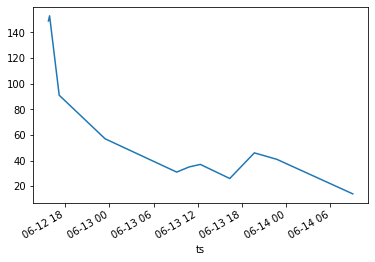

In [17]:
drivers_a.groupby('ts')['12 Hour'].agg(lambda x: x[x > 0].sum()).plot()

In [16]:
drivers_a.groupby('ts')['12 Hour'].agg(lambda x: x[x < 0].sum()).abs()

ts
2022-06-12 15:42:57    107
2022-06-12 15:52:24    107
2022-06-12 17:10:49     57
2022-06-12 23:24:40     32
2022-06-13 09:07:54     17
2022-06-13 10:48:36     19
2022-06-13 12:20:15     20
2022-06-13 16:20:06     19
2022-06-13 19:40:38     19
2022-06-13 22:42:39     16
2022-06-14 09:02:22      7
Name: 12 Hour, dtype: int64